In [73]:
%matplotlib inline
from activ import load_data
from activ.data_normalization import data_normalization
from activ.analytics import nmf_bases_heatmap
from PyUoI.UoINMF import UoINMF
from hdbscan import HDBSCAN
from sklearn.model_selection import KFold

import numpy as np
import matplotlib.pyplot as plt

In [41]:
def intersect(samples, **kwargs):
    selected = np.all(samples > 0.0, axis=0)
    ret = np.zeros(samples.shape[1])
    ret[selected] = np.mean(samples, axis=0)[selected]
    return ret

In [42]:
data = load_data()
data.biomarkers.shape
ocnorm = data_normalization(data.outcomes, 'positive')
bmnorm = data_normalization(data.biomarkers, 'positive')

In [72]:
nboot = 20
minpts = 20
seed = 1
uoinmf = UoINMF(n_bootstraps=nboot, ranks=list(range(2,10)), random_state=seed,
                    dbscan=HDBSCAN(min_cluster_size=minpts, core_dist_n_jobs=1))

In [96]:
_data = ocnorm
kf = KFold(n_splits=4)
n_boot = 20
min_pts = (5, 10, 15, 20, 25, 35, 45)
rec_err = np.zeros((kf.get_n_splits(), len(min_pts)))
k = 0
for test, train in kf.split(_data):
    for i in range(len(min_pts)):
        uoinmf = UoINMF(n_bootstraps=n_boot, ranks=list(range(2,10)),
                    dbscan=HDBSCAN(min_cluster_size=min_pts[i], core_dist_n_jobs=1))
        uoinmf.fit(_data[train])
        tfm = uoinmf.transform(_data[test])
        rec_err[k, i] = uoinmf.reconstruction_err_
    k += 1

rec_error = np.mean(rec_err, axis=0)

In [97]:
rec_error

array([41.66258193, 46.01493189, 47.496974  , 48.41886686, 48.2979286 ,
       48.22921817, 48.84127164])

In [98]:
rec_err

array([[42.54311538, 46.05215927, 48.19759035, 50.45304783, 50.53479016,
        50.27987262, 51.57105181],
       [41.71614343, 47.86043565, 48.21590961, 48.41807241, 48.91249782,
        48.64145394, 48.32207874],
       [40.37207848, 44.10921444, 46.37746165, 46.82826453, 46.24071159,
        46.83474288, 47.35918061],
       [42.01899043, 46.03791819, 47.19693437, 47.97608269, 47.50371482,
        47.16080323, 48.11277539]])

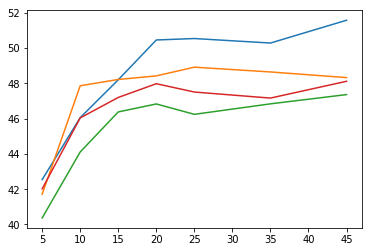

In [99]:
plt.plot(min_pts, rec_err.T)

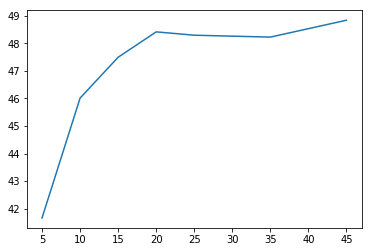

In [100]:
plt.plot(min_pts, rec_error)

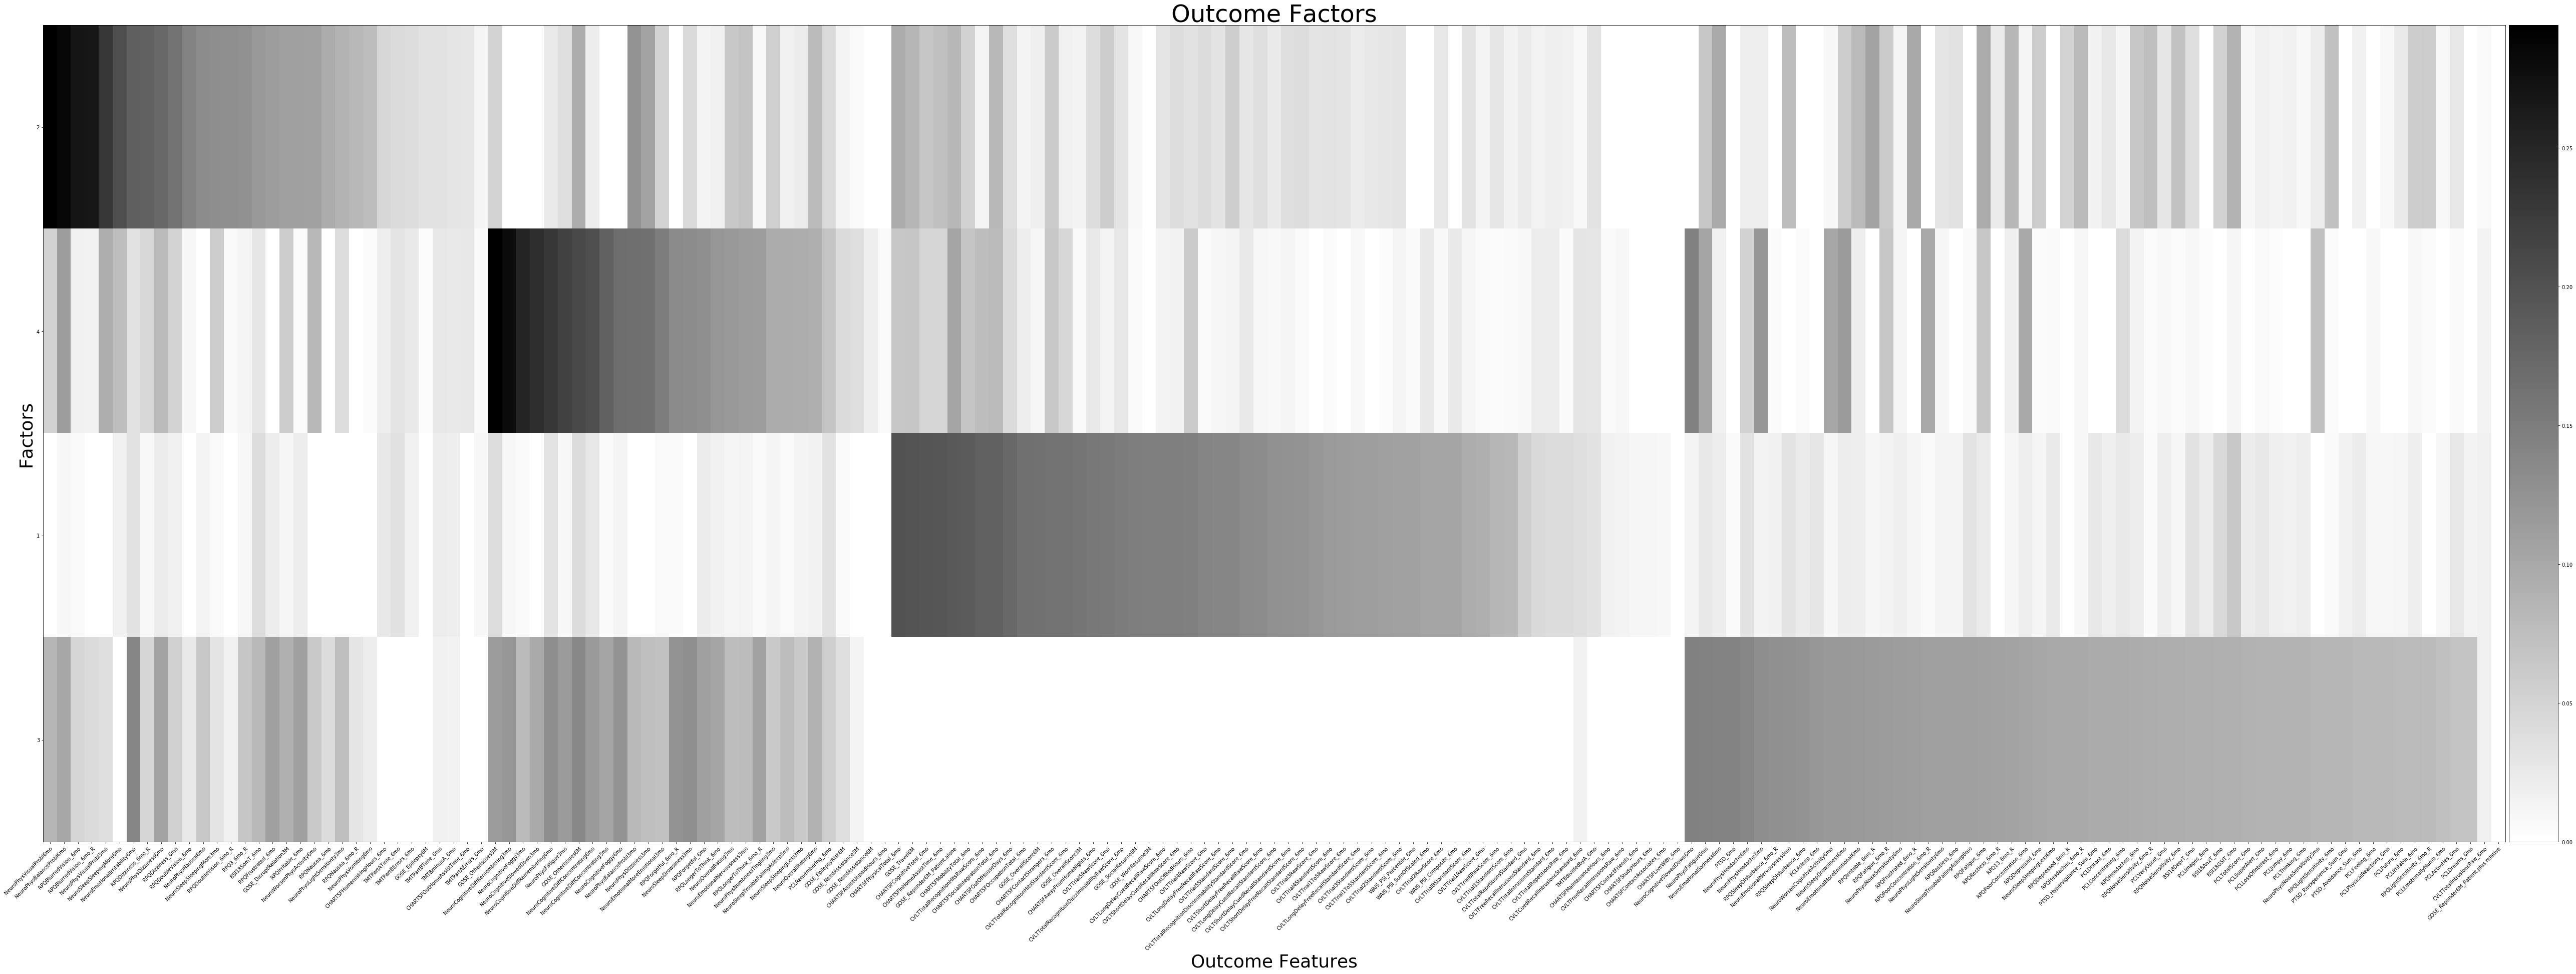

In [70]:
plt.figure(figsize=(90, 30))
nmf_bases_heatmap(uoinmf.components_, col_labels=data.outcome_features, sort=True, ax=None,
            cbar_kw={}, cbarlabel="", xlab='Outcome Features', ylab='Factors', aspect='auto',
            title='Outcome Factors')